<a href="https://colab.research.google.com/github/anjishnub/Interpolation_Information_Geometry/blob/main/Interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

## The point of this project is to interpolate and find a distribution where the input distributions f(x) is a function of some parmeter vector $\alpha$. Given $f(x|\alpha)$ at $\alpha= \alpha_), \alpha_1, \alpha_2,$ the goal is to find $f(x|\alpha')$  for any $\alpha'$.

In [2]:
import numpy as np
from scipy import stats 
import numpy.linalg as linalg
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import manifold
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize
import scipy.optimize
from math import sqrt
from scipy.spatial import Delaunay

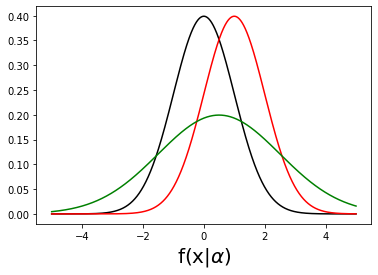

In [3]:


# dim = 1+#dim parameters = dim of embedding
dim = 3 


# for starters, define a parametrized family of functions explicitly and draw from it
# Here as the test case gaussian distributions are used.
#parameter points for any gaussian distribution is mean and standard deviation \alpha
alphas = np.array([[0,0],[1,0],[0.5,1]])
f = lambda alpha: lambda x : np.exp(-(x-alpha[0])**2 / (2*(alpha[1]+1)**2))/(np.sqrt(2*np.pi)*(alpha[1]+1))

dists=[]

for alpha in alphas:
    dists.append( f(alpha) )
    
xarray = np.linspace(-5,5,10000)
plt.plot(xarray,dists[0](xarray),c='black')
plt.plot(xarray,dists[1](xarray),c='r')
plt.plot(xarray,dists[2](xarray),c='g')

plt.xlabel(r'f(x|$\alpha$)', fontsize = 20)
plt.show()

## Calculate pair-wise chord distances, embed on n-sphere, & rotate first to south pole

It's going to be easier to work in the space of the sqrt of distributions, so let's define a simple transformation q 

In [4]:
q = lambda h: (lambda x: np.sqrt(h(x)))

In [5]:
def inner_product(q1,q2, xmin=-10, xmax=10):
    # this is a simple numeric integration
    num = 10000
    xarray = np.linspace(xmin,xmax,num)
    return np.sum(q1(xarray) * q2(xarray))*(xmax-xmin)/num

In [6]:
(inner_product(q(dists[0]),q(dists[0])), inner_product(q(dists[1]),q(dists[1])),inner_product(q(dists[2]),q(dists[2])))

(0.9999, 0.9999000000000002, 0.9998989096954712)

## Create pairs of (parameter simplex, Gnomonic simplex)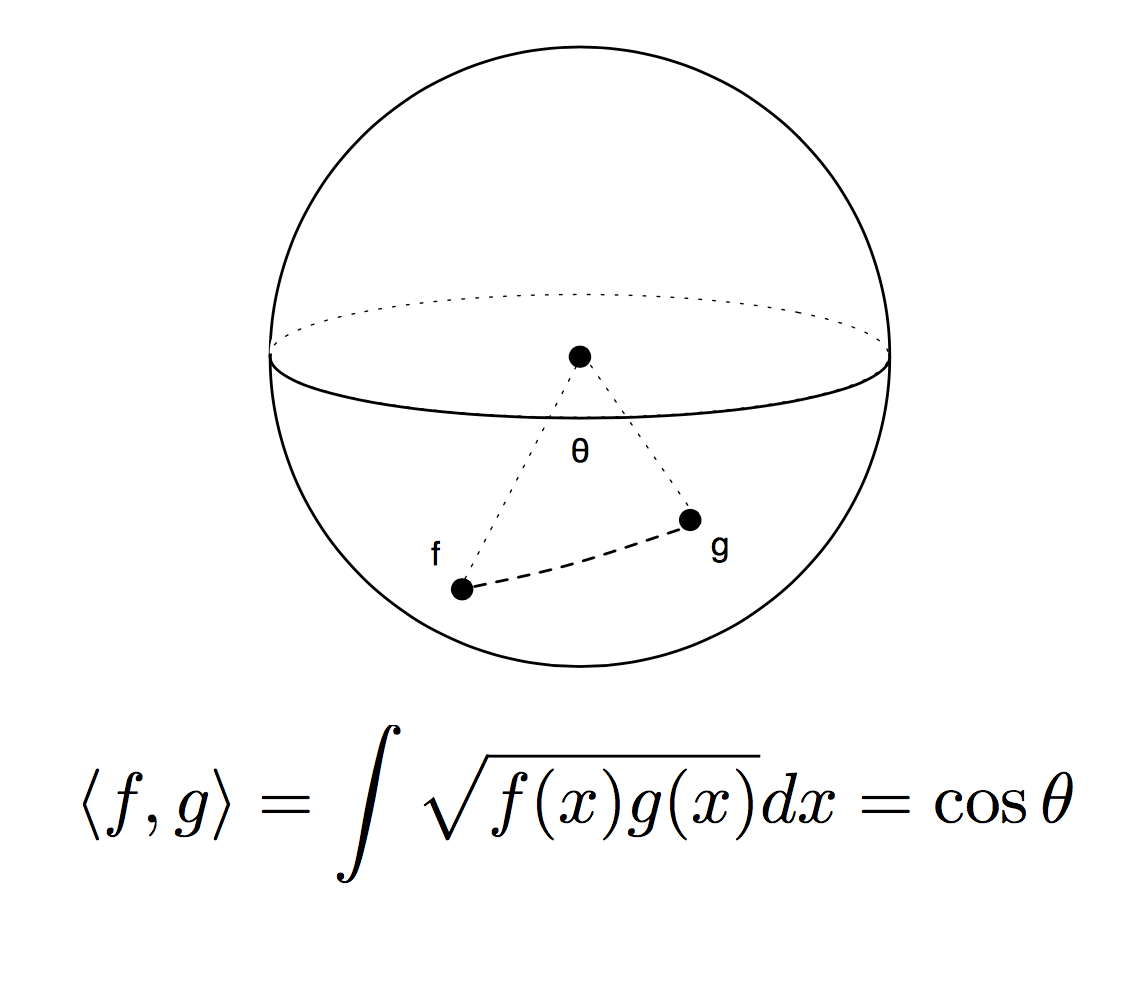

In [7]:
def getChordDistance(q1,q2):
    return (np.arccos( inner_product(q1, q2) )) 

In [8]:
tempSim=[]
for f1 in dists:
    temp = []
    for f2 in dists:
        temp.append(getChordDistance(q(f1),q(f2)))
    tempSim.append(temp)
chordDistMatrix=np.array(tempSim)
chordDistMatrix #diagonals should be close to 0

array([[0.01414225, 0.48983893, 0.48809435],
       [0.48983893, 0.01414225, 0.48809435],
       [0.48809435, 0.48809435, 0.01421914]])

## Calculating the matrix by embedding the distributions on a n-sphere(here it is a normal sphere) 
##The first point is embedded to the south pole of the sphere
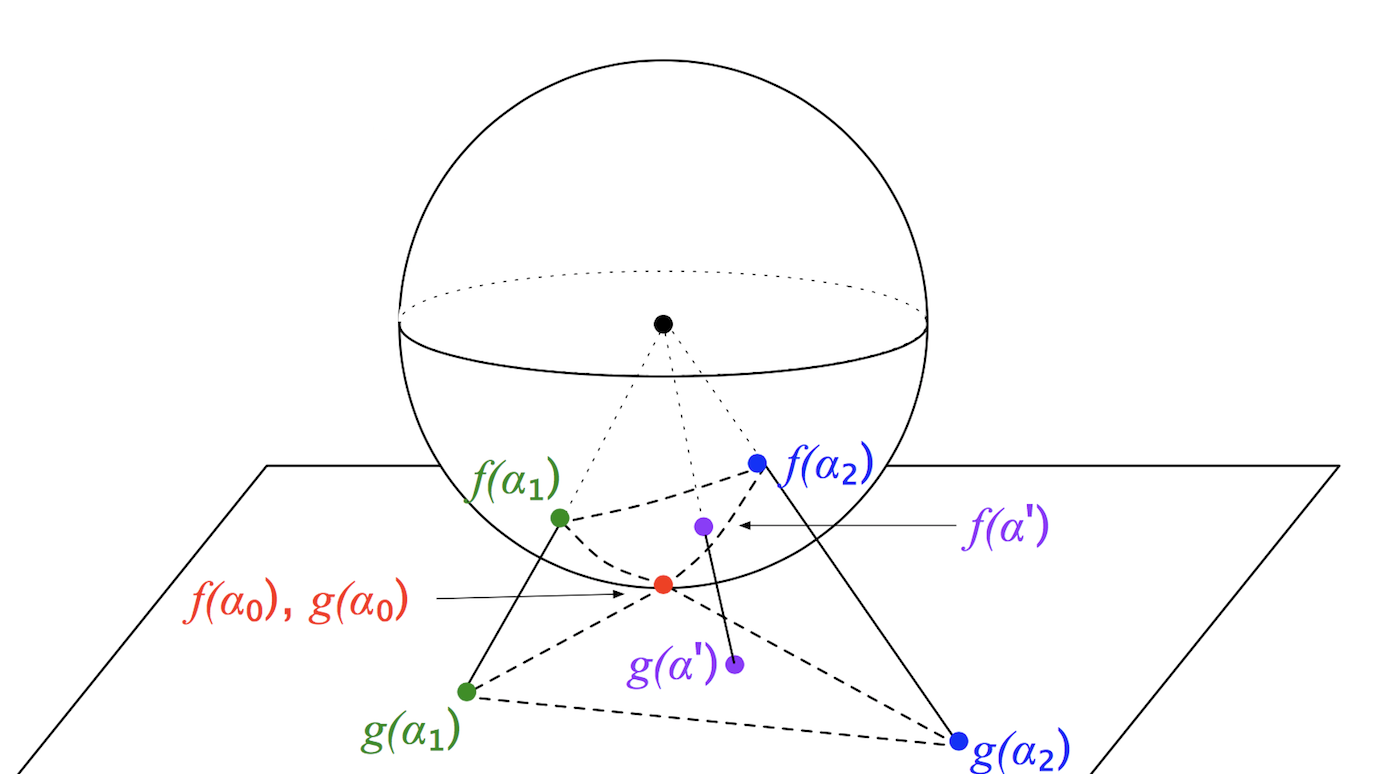



In [9]:
## Embeding functions onto n-sphere
n=dim-1
embeded=np.zeros(shape=(dim,dim))
#The first point is embedded to the south pole of the sphere
embeded[0]=[0,0,-1]
a=np.array([[-1], [2,3]], dtype=object)
#This is an algorithm to embed the points on the sphere by preserving distances.
for k in range(1,dim):
    y=np.empty([k,k])
    z=np.zeros(k)
    for j in range(0,k):
        z[j]=1-(chordDistMatrix[j][k]**2)*0.5
        y[j]=np.delete(embeded[j],np.arange(n+1-k))
    x = np.linalg.solve(y,z)
    x_0k=-sqrt(1-np.sum(x**2)) #negative sign to keep it totally in southern hemisphere
    a=np.append(x_0k,x)
    embeded[k]=np.append(np.zeros(n-k),a)
embeded

array([[ 0.        ,  0.        , -1.        ],
       [ 0.        , -0.47492011, -0.88002891],
       [-0.41776879, -0.22252241, -0.88088195]])

In [10]:
pointsOnSphere = embeded.copy()

## The spheres are projected using a gnomonic projection on a plane
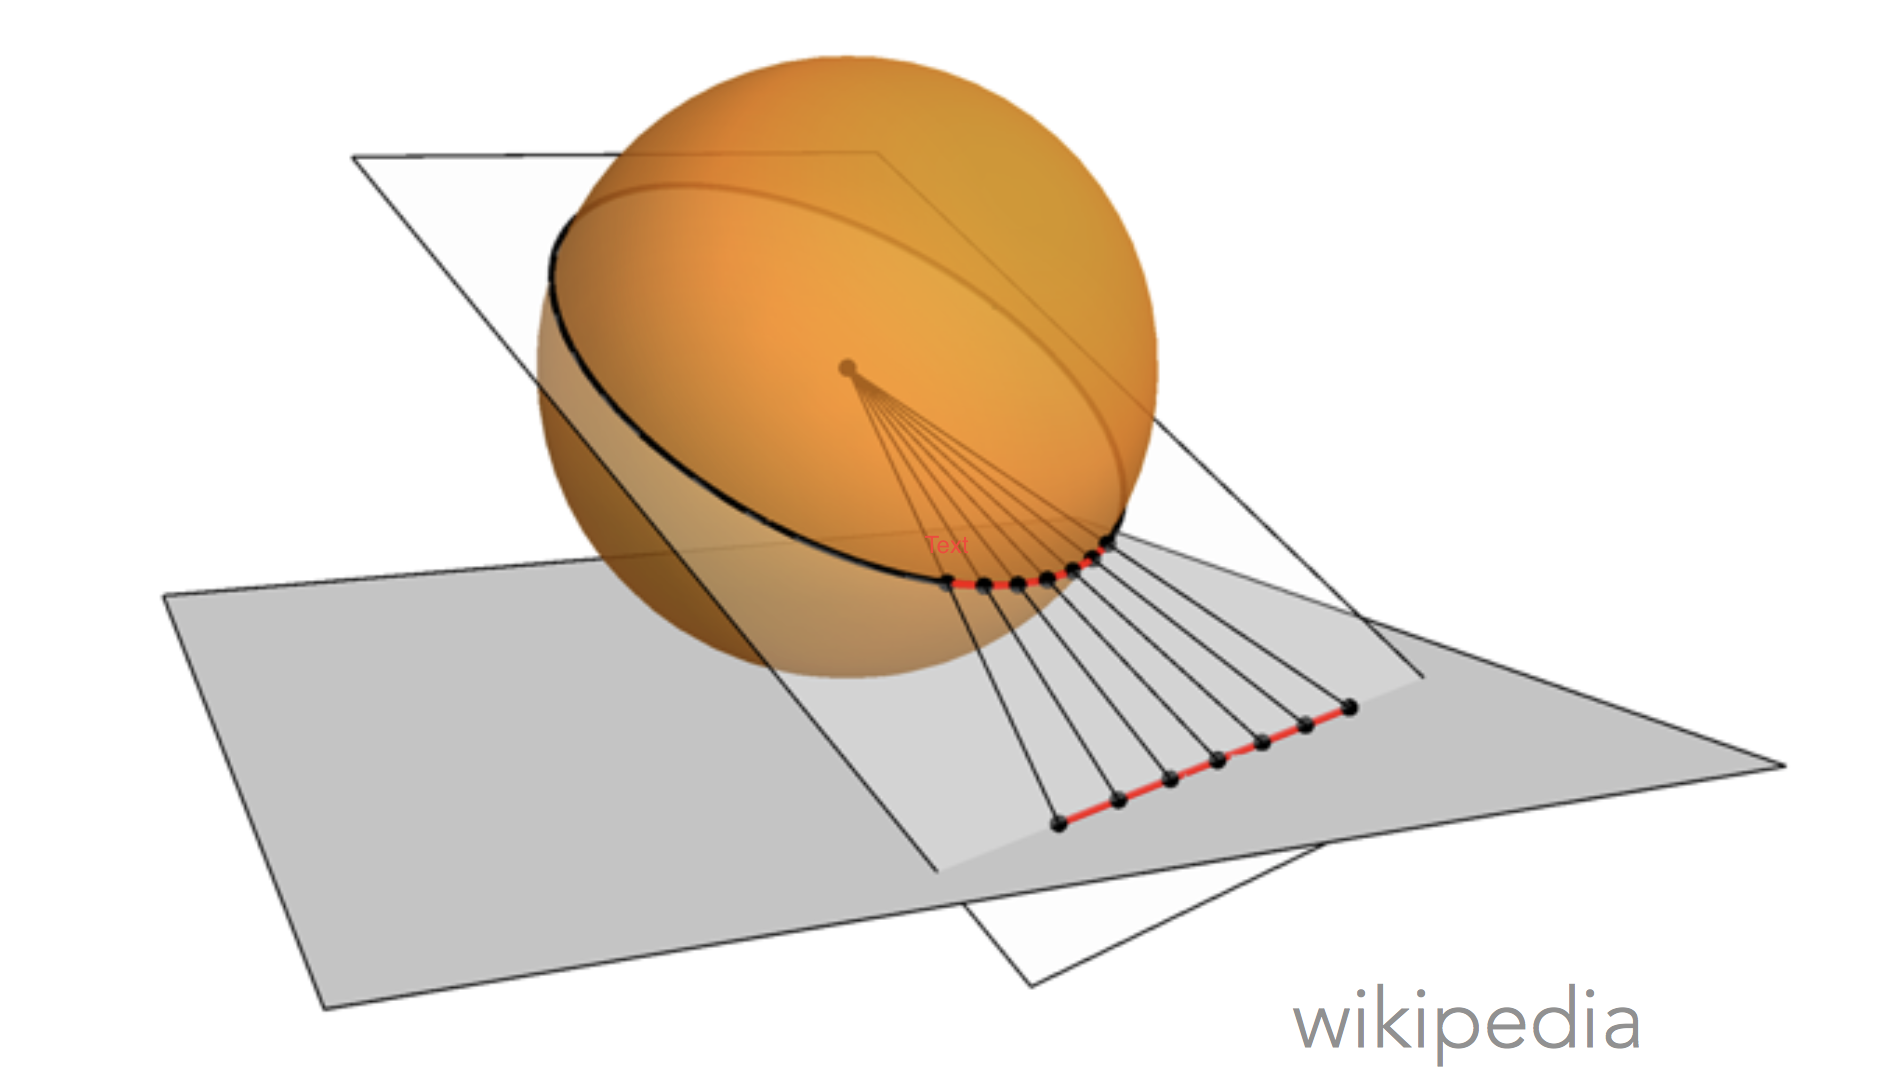

In [11]:
gnomonicProjection = pointsOnSphere.copy()
for i, point in enumerate(pointsOnSphere):
    gnomonicProjection[i] = -1.*point/point[2]
gnomonicProjection

array([[ 0.        ,  0.        , -1.        ],
       [ 0.        , -0.53966421, -1.        ],
       [-0.47426194, -0.2526132 , -1.        ]])

In [12]:
nSamples = 15 #samples along ray for visualization
rays = np.zeros((3*nSamples,dim))
for i, point in enumerate(gnomonicProjection):
    for j, c in enumerate(np.linspace(0,1,nSamples)):
        rays[i*nSamples+j] = c * point

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


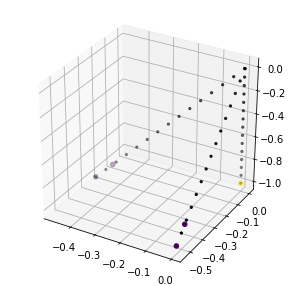

In [13]:
fig = plt.figure(figsize=(5,5))
subpl = fig.add_subplot(111,projection='3d')
subpl.scatter(rays[:, 0], rays[:, 1], rays[:, 2],marker='.',c=pointsOnSphere[:,0]*0+.01)
subpl.scatter(pointsOnSphere[:, 0], pointsOnSphere[:, 1],pointsOnSphere[:, 2],
              marker='o',c=-pointsOnSphere[:,2])#,cmap=mpl.cm.gray)
subpl.scatter(gnomonicProjection[:, 0], gnomonicProjection[:, 1], gnomonicProjection[:, 2],
              c=-pointsOnSphere[:,2])#,cmap=mpl.cm.gray)
plt.show()

In [14]:
alphaSimplex = Delaunay(alphas)
gnomonicSimplex = Delaunay(gnomonicProjection[:3,:2])

In [15]:
normedVertices = gnomonicProjection[:3,:2].copy()
normedVertices[1] /= linalg.norm(normedVertices[1])
normedVertices[2] /= linalg.norm(normedVertices[2])
normedSimplex = Delaunay(normedVertices)
normedVertices

array([[ 0.        ,  0.        ],
       [ 0.        , -1.        ],
       [-0.88260512, -0.4701151 ]])

In [16]:
#alpha is the target vector. This is G(0.5,1)
alpha = np.array([0.5,0])
baryCoords = alphaSimplex.transform[0,:dim-1,:].dot(alpha)
print (baryCoords)
gnomonicTarget = linalg.inv(gnomonicSimplex.transform[0,:dim-1,:]).dot(baryCoords)
print (gnomonicTarget)
normedBaryCoords = normedSimplex.transform[0,:dim-1,:].dot(gnomonicTarget)
t = np.arctan(linalg.norm(gnomonicTarget))
t 
#normedBaryCoords #linalg.norm(gnomonicTarget), linalg.norm(gnomonicProjection[1,:2]), linalg.norm(gnomonicProjection[2,:2])
alphaSimplex.transform[0,:dim-1]

[0.5 0. ]
[ 0.23713097 -0.14352551]


array([[ 1. , -0.5],
       [ 0. ,  1. ]])

In [17]:
dot01 = inner_product(q(dists[0]),q(dists[1]))
dot02 = inner_product(q(dists[0]),q(dists[2]))
t1 = lambda x: q(dists[1])(x) - dot01*q(dists[0])(x)
t2 = lambda x: q(dists[2])(x) - dot02*q(dists[0])(x)
norm1 = inner_product(t1,t1)
norm2 = inner_product(t2,t2)
u1 = lambda x: t1(x)/np.sqrt(norm1)
u2 = lambda x: t2(x)/np.sqrt(norm2)
#unnorm_tan = lambda x: u1(x)*normedBaryCoords[1] + u2(x)*normedBaryCoords[0]
unnorm_tan = lambda x: u1(x)*normedBaryCoords[0]+u2(x)*normedBaryCoords[1]
norm_tan = inner_product(unnorm_tan,unnorm_tan)
tangent = lambda x: unnorm_tan(x) / np.sqrt(norm_tan)
#tangent = lambda x: (u1(x)*normedBaryCoords[1] + u2(x)*normedBaryCoords[0])/np.sqrt(norm_tan)
#tangent = lambda x: (u1(x)*normedBaryCoords[0] + u2(x)*normedBaryCoords[1])/np.sqrt(norm_tan)
#print inner_product(q(dists[0]),tangent), inner_product(tangent,tangent)
q_interpolant = lambda x: np.cos(t)*q(dists[0])(x) + np.sin(t)*tangent(x) 
interpolant = lambda x: ( np.cos(t)*q(dists[0])(x) + np.sin(t)*tangent(x) )**2
#interpolant = lambda x: (q_interpolant(x)*q_interpolant(x))
#interpolant = lambda x: ( np.cos(t)*q(dists[0])(x) + np.sin(t)*u1(x) )**2

np.arccos(inner_product(q(interpolant),q(dists[0]))),inner_product(q(interpolant),q(interpolant))

(0.2705685252182947, 1.0000035060060566)

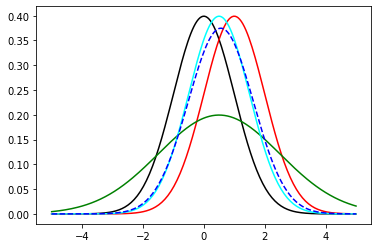

In [18]:
dists.append(f(alpha))
xarray = np.linspace(-5,5,200)
plt.plot(xarray,dists[0](xarray),c='black')
plt.plot(xarray,dists[1](xarray),c='r')
plt.plot(xarray,dists[2](xarray),c='g')
plt.plot(xarray,dists[3](xarray),c='cyan')
plt.plot(xarray,interpolant(xarray),c='b',ls='dashed')


plt.show()


#The dotted curve is the interpolated distribution.It should match with a Gausian of G(0.5,1). The cyan curve is G(0.5,1).